# Benchmark Milo - pertpy vs miloR

Setting up the environment
```shell
conda create --name pertpy-milo-benchmark python=3.12 conda-forge::r-base pip
pip install rpy2==3.5.10
conda install -c conda-forge r-systemfonts libxml2
```
Start R session
```r
> R.home() # check location is within environment
> install.packages('BiocManager')
> BiocManager::install('miloR')
> q()
```
Now install pertpy
```
pip install pertpy[de]
```

In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pertpy as pt
import scanpy as sc
import seaborn as sns
from scipy import io, sparse

In [4]:
from scipy.signal import convolve, convolve2d, gaussian

ImportError: cannot import name 'gaussian' from 'scipy.signal' (/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/scipy/signal/__init__.py)

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(SingleCellExperiment)
library(miloR)

## Convert Stephenson dataset to SingleCellExperiment

In [2]:
adata = pt.dt.stephenson_2021_subsampled()
adata = adata[adata.obs["Status"] != "LPS"].copy()

Output()

In [3]:
# Convert elements to make R object (we don't need expression data)
obs = adata.obs
obsm_scvi = adata.obsm["X_scVI"]
obsm_umap = adata.obsm["X_umap"]

In [17]:
%%R -i obs -i obsm_scvi -i obsm_umap
sce = SingleCellExperiment(
    colData = obs,
    reducedDims = list(
        scvi = obsm_scvi,
        umap = obsm_umap
    ))

saveRDS(sce, 'data/stephenson_2021_subsampled.rds')

## Milo analysis with miloR

In [3]:
%%R 
library(dplyr)
library(ggplot2)

sce <- readRDS('data/stephenson_2021_subsampled.rds')
counts(sce) <- NULL
logcounts(sce) <- NULL
milo.obj <- Milo(sce)

# Build graph
milo.obj <- buildGraph(milo.obj, k=150, d=10, reduced.dim="scvi")
milo.obj <- makeNhoods(milo.obj, k=150, d=10, refined=TRUE, prop=0.1, refinement_scheme="graph")

# Count cells per patient
patient_metadata <- data.frame(colData(sce)) %>%
    dplyr::select(patient_id, Status, Site) 
    
milo.obj <- countCells(milo.obj, samples="patient_id", meta.data=patient_metadata)

# DA testing
design_df <- patient_metadata %>% distinct()
rownames(design_df) <- design_df$patient_id
design_df$Status <- factor(design_df$Status, levels=c('Healthy', 'Covid'))
milo_res <- testNhoods(
    milo.obj, 
    design=~Site+Status, 
    design.df=design_df, 
    reduced.dim="scvi",
    fdr.weighting="graph-overlap")

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    combine


R[write to console]: The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:GenomeInfoDb’:

    intersect


R[write to console]: The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:matrixStats’:

    count


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from

R[write to console]: Adding nhood effect sizes to neighbourhood graph attributes



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


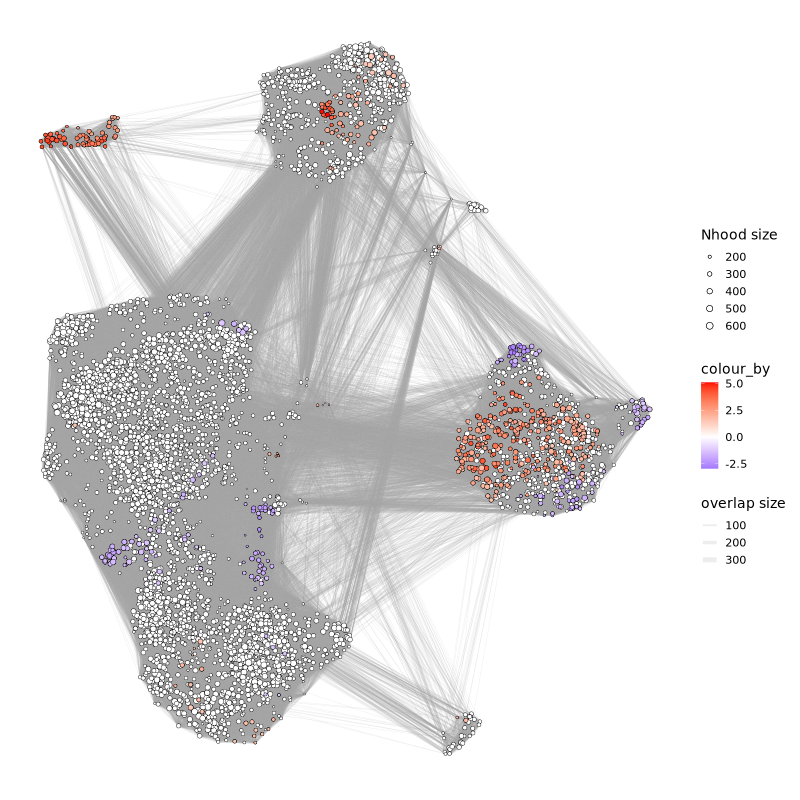

In [4]:
%%R -w 800 -h 800
# Visualize results in R plot
milo.obj <- buildNhoodGraph(milo.obj)
nh_graph_pl <- plotNhoodGraphDA(milo.obj, milo_res, layout="umap",alpha=0.01) 
nh_graph_pl + scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)

In [7]:
%%R
# Save outputs to load on anndata object
write.csv(milo_res, "data/stephenson_2021_subsampled.miloR_milo.csv")
Matrix::writeMM(nhoods(milo.obj), "data/stephenson_2021_subsampled.miloR_milo.nhoods.mtx")

NULL


## Milo analysis with pertpy

Replicating tutorial https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/milo.html

In [ ]:
adata = pt.dt.stephenson_2021_subsampled()
adata = adata[adata.obs["Status"] != "LPS"].copy()

## Initialize object for Milo analysis
milo = pt.tl.Milo()
mdata = milo.load(adata)

In [21]:
# Build KNN graph
sc.pp.neighbors(mdata["rna"], use_rep="X_scVI", n_neighbors=150)

# Make nhoods
milo.make_nhoods(mdata["rna"], prop=0.1)

# Counts cells in nhoods
mdata = milo.count_nhoods(mdata, sample_col="patient_id")

# Test for differential abundance associated with COVID
mdata["rna"].obs["Status"] = mdata["rna"].obs["Status"].cat.reorder_categories(["Healthy", "Covid"])
milo.da_nhoods(mdata, design="~Site+Status", model_contrasts="StatusCovid")

In [60]:
## Save results
mdata.write_h5mu("data/stephenson_2021_subsampled.pertpy_milo.h5mu")

In [4]:
# import mudata
# mdata = mudata.read_h5mu("data/stephenson_2021_subsampled.pertpy_milo.h5mu")

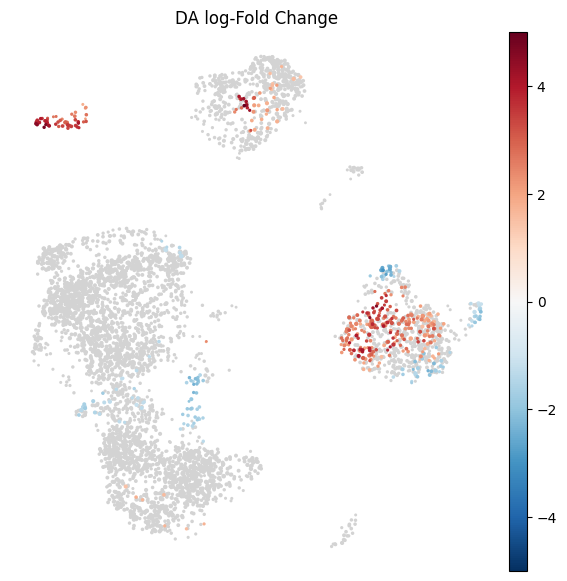

In [8]:
milo = pt.tl.Milo()
milo.build_nhood_graph(mdata)
plt.rcParams["figure.figsize"] = [7, 7]
milo.plot_nhood_graph(
    mdata,
    alpha=0.01,  ## SpatialFDR level (1%)
    min_size=0.1,  ## Size of smallest dot
)

## Compare results at cell level

In [ ]:
## Utils for comparison on cell-level results
def milo2cell_results(
    adata: anndata.AnnData,
    results_df: pd.DataFrame,
    nhoods_matrix: sparse.spmatrix,
    significance_threshold: float = 0.1,
    prefix: str = "milo_",
) -> anndata.AnnData:
    """Calculate mean logFC for each cell based on their group memberships and add results
    to adata.obs.

    Parameters:
    -----------
    adata : anndata.AnnData
        AnnData object with n cells
    results_df : pandas.DataFrame
        DataFrame containing 'logFC' and 'SpatialFDR' columns for each group
    nhoods_matrix : scipy.sparse.matrix
        Sparse binary matrix (n_cells x n_groups) indicating group membership
    significance_threshold : float
        Threshold for SpatialFDR to consider results significant (default: 0.1)
    prefix : str
        Prefix to add to the new columns in adata.obs (default: "milo_")

    Returns:
    --------
    anndata.AnnData
        Modified AnnData object with new columns in .obs:
        - {prefix}mean_logFC: Mean logFC values for each cell
        - {prefix}is_significant: Boolean indicating if cell belongs to any significant group
        - {prefix}n_sig_groups: Number of significant groups the cell belongs to
    """
    # Verify dimensions match
    if nhoods_matrix.shape[0] != adata.n_obs:
        raise ValueError(
            f"Number of cells in nhoods_matrix ({nhoods_matrix.shape[0]}) "
            f"does not match number of cells in adata ({adata.n_obs})"
        )

    # Convert sparse matrix to CSR format if it isn't already
    nhoods_csr = nhoods_matrix.tocsr()

    # Create array of logFC values matching the groups
    logfc_values = results_df["logFC"].values

    # Calculate sum of logFC for each cell's groups
    significant_mask = results_df["SpatialFDR"] < significance_threshold
    masked_logfc = np.where(significant_mask, logfc_values, 0)
    cell_logfc_sums = nhoods_csr.dot(masked_logfc)

    # Calculate number of significant groups each cell belongs to
    significant_mask = results_df["SpatialFDR"] < significance_threshold
    n_sig_groups = nhoods_csr.dot(significant_mask.astype(int))

    # Calculate mean (avoiding division by zero)
    cell_mean_logfc = np.zeros_like(cell_logfc_sums)
    mask = n_sig_groups > 0
    cell_mean_logfc[mask] = cell_logfc_sums[mask] / n_sig_groups[mask]

    # Add results to adata.obs
    adata.obs[f"{prefix}mean_logFC"] = cell_mean_logfc
    adata.obs[f"{prefix}is_significant"] = n_sig_groups > 0
    adata.obs[f"{prefix}n_sig_groups"] = n_sig_groups

In [38]:
results_dict = {
    "pertpy_": (mdata["milo"].var, mdata["rna"].obsm["nhoods"]),
    "miloR_": (
        pd.read_csv("data/stephenson_2021_subsampled.miloR_milo.csv"),
        io.mmread("data/stephenson_2021_subsampled.miloR_milo.nhoods.mtx"),
    ),
}

for k, v in results_dict.items():
    results_df, nhoods_matrix = v
    milo2cell_results(
        adata,
        results_df=results_df,
        nhoods_matrix=nhoods_matrix,
        prefix=k,
        significance_threshold=1.0,
    )

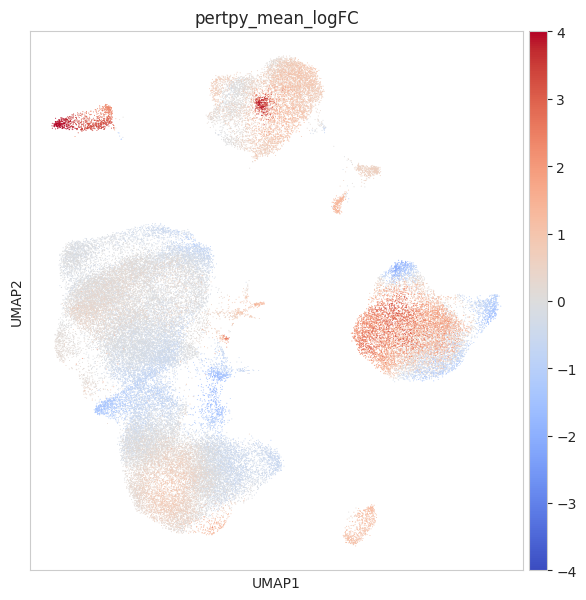

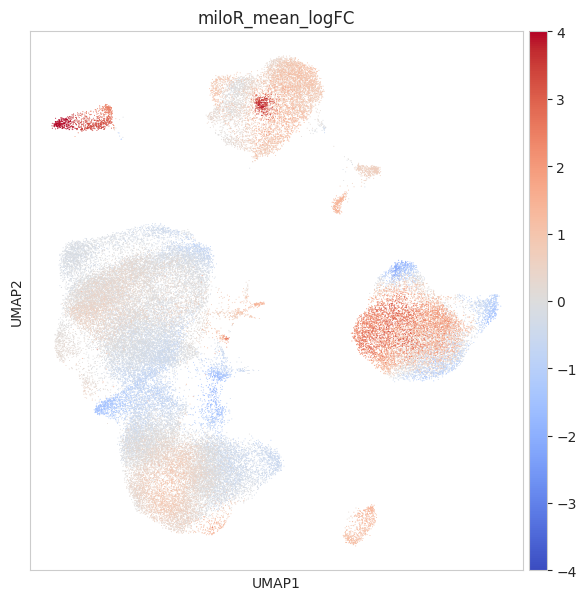

In [39]:
sc.pl.umap(adata, color=["pertpy_mean_logFC"], cmap="coolwarm", vmin=-4, vmax=4, ncols=2)
sc.pl.umap(adata, color=["miloR_mean_logFC"], cmap="coolwarm", vmin=-4, vmax=4, ncols=2);

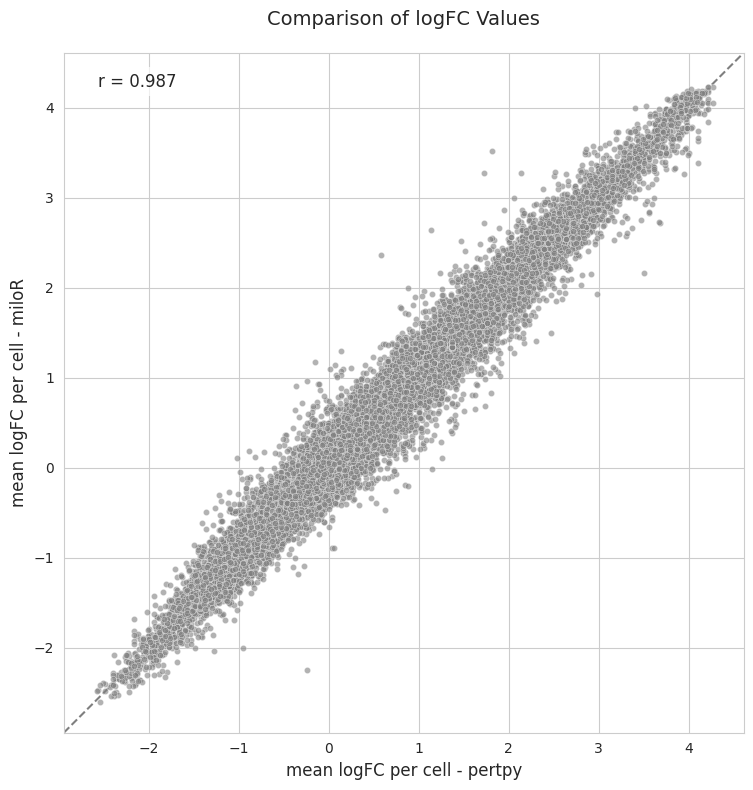

In [40]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    data=adata.obs,
    x="pertpy_mean_logFC",
    y="miloR_mean_logFC",
    alpha=0.6,
    s=20,  # smaller points
    color="gray",  # gray color
    ax=ax,
)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, "k--", alpha=0.5, zorder=0, label="y=x")
ax.set_xlim(lims)
ax.set_ylim(lims)

# Calculate and add correlation
correlation = adata.obs["pertpy_mean_logFC"].corr(adata.obs["miloR_mean_logFC"])
ax.text(
    0.05,
    0.95,
    f"r = {correlation:.3f}",
    transform=ax.transAxes,
    fontsize=12,
    bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.7},
)

ax.set_xlabel("mean logFC per cell - pertpy", fontsize=12)
ax.set_ylabel("mean logFC per cell - miloR", fontsize=12)
plt.title("Comparison of logFC Values", fontsize=14, pad=20)
ax.set_aspect("equal")

plt.tight_layout()

plt.show()

# Optional: Save figure
# plt.savefig('logFC_comparison.pdf', dpi=300, bbox_inches='tight')

Check recall of cells belonging to neighbourhoods significanlty enriched or depleted in disease

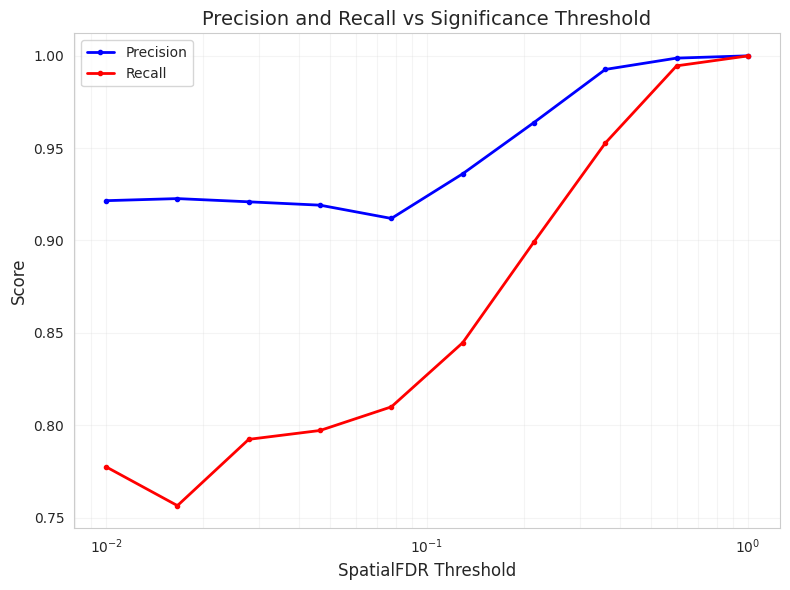

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Define thresholds
thresholds = np.logspace(-2, 0, num=10)  # 10 points from 0.01 to 0.1

# Store results
results = []

# Calculate precision and recall for each threshold
for thresh in thresholds:
    # Compute results for both methods with current threshold
    for k, v in results_dict.items():
        results_df, nhoods_matrix = v
        milo2cell_results(
            adata,
            results_df=results_df,
            nhoods_matrix=nhoods_matrix,
            prefix=k,
            significance_threshold=thresh,
        )

    milo_sig = adata.obs["miloR_is_significant"]
    pertpy_sig = adata.obs["pertpy_is_significant"]

    # Calculate metrics
    recall = recall_score(milo_sig, pertpy_sig)  # (what fraction of miloR significant cells did pertpy find?)
    precision = precision_score(
        milo_sig, pertpy_sig
    )  #  (what fraction of pertpy significant cells were also significant in miloR?)

    results.append({"threshold": thresh, "recall": recall, "precision": precision})

results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))

# Plot both metrics
plt.plot(
    results_df["threshold"],
    results_df["precision"],
    "b.-",
    label="Precision",
    linewidth=2,
)
plt.plot(results_df["threshold"], results_df["recall"], "r.-", label="Recall", linewidth=2)

plt.xscale("log")
plt.xlabel("SpatialFDR Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision and Recall vs Significance Threshold", fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

plt.tight_layout()
plt.show()